Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
fatal: destination path 'PV-Multi-Defect' already exists and is not an empty directory.
Dataset contents:
  📁 Annotations: 1107 files
  📄 tf5.jpg
  📄 README.md
  📄 tf1.jpg
  📄 tf3.jpg
  📄 tf2.jpg
  📄 tf4.jpg
  📁 JPEGImages: 1109 files
  📁 .git: 11 files

Images count: 1109
Annotations count: 1107
Loading dataset...
Dataset initialized with 1105 labeled images
Class distribution:
  broken: 68 samples
  bright_spot: 198 samples
  black_border: 151 samples
  scratched: 612 samples
  non_electricity: 76 samples

Dataset split:
Total samples: 1105
Training samples: 773
Validation samples: 165
Test samples: 167

Data loaders created with batch size: 32

Initializing model...
Total parameters: 24,559,685
Trainable parameters: 16,016,389
Resuming from checkpoint: /content/models/checkpoint_epoch_29.pth

Starting tr

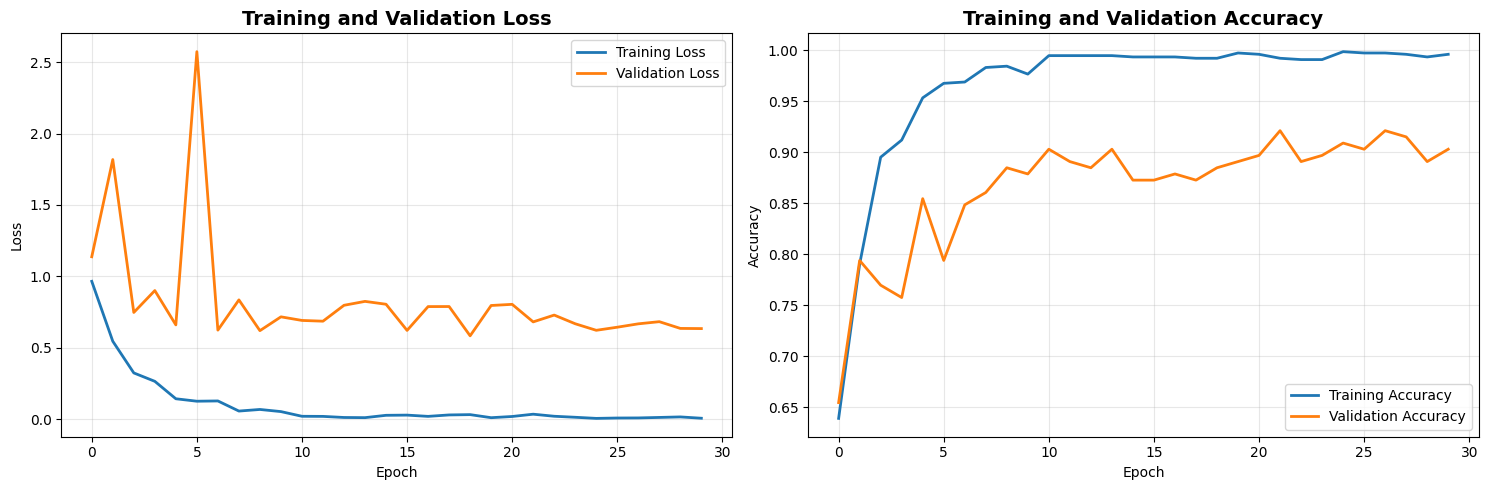


Loading best model for evaluation...
Evaluating on test set...


Testing: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]



FINAL MODEL EVALUATION
Test Accuracy: 0.9401 (94.01%)

Classification Report:
                 precision    recall  f1-score   support

         broken     1.0000    0.7857    0.8800        14
    bright_spot     0.9333    0.9655    0.9492        29
   black_border     0.9688    0.9394    0.9538        33
      scratched     0.9176    1.0000    0.9571        78
non_electricity     1.0000    0.6923    0.8182        13

       accuracy                         0.9401       167
      macro avg     0.9639    0.8766    0.9116       167
   weighted avg     0.9438    0.9401    0.9378       167



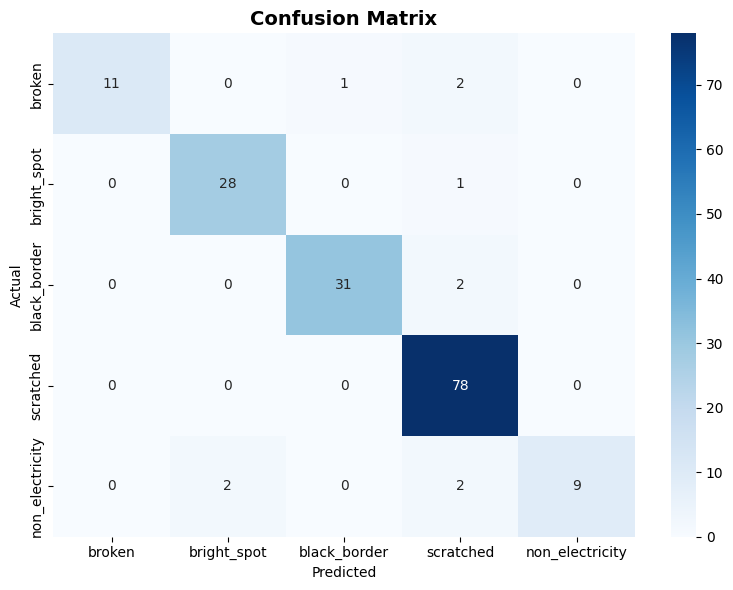


Visualizing predictions...


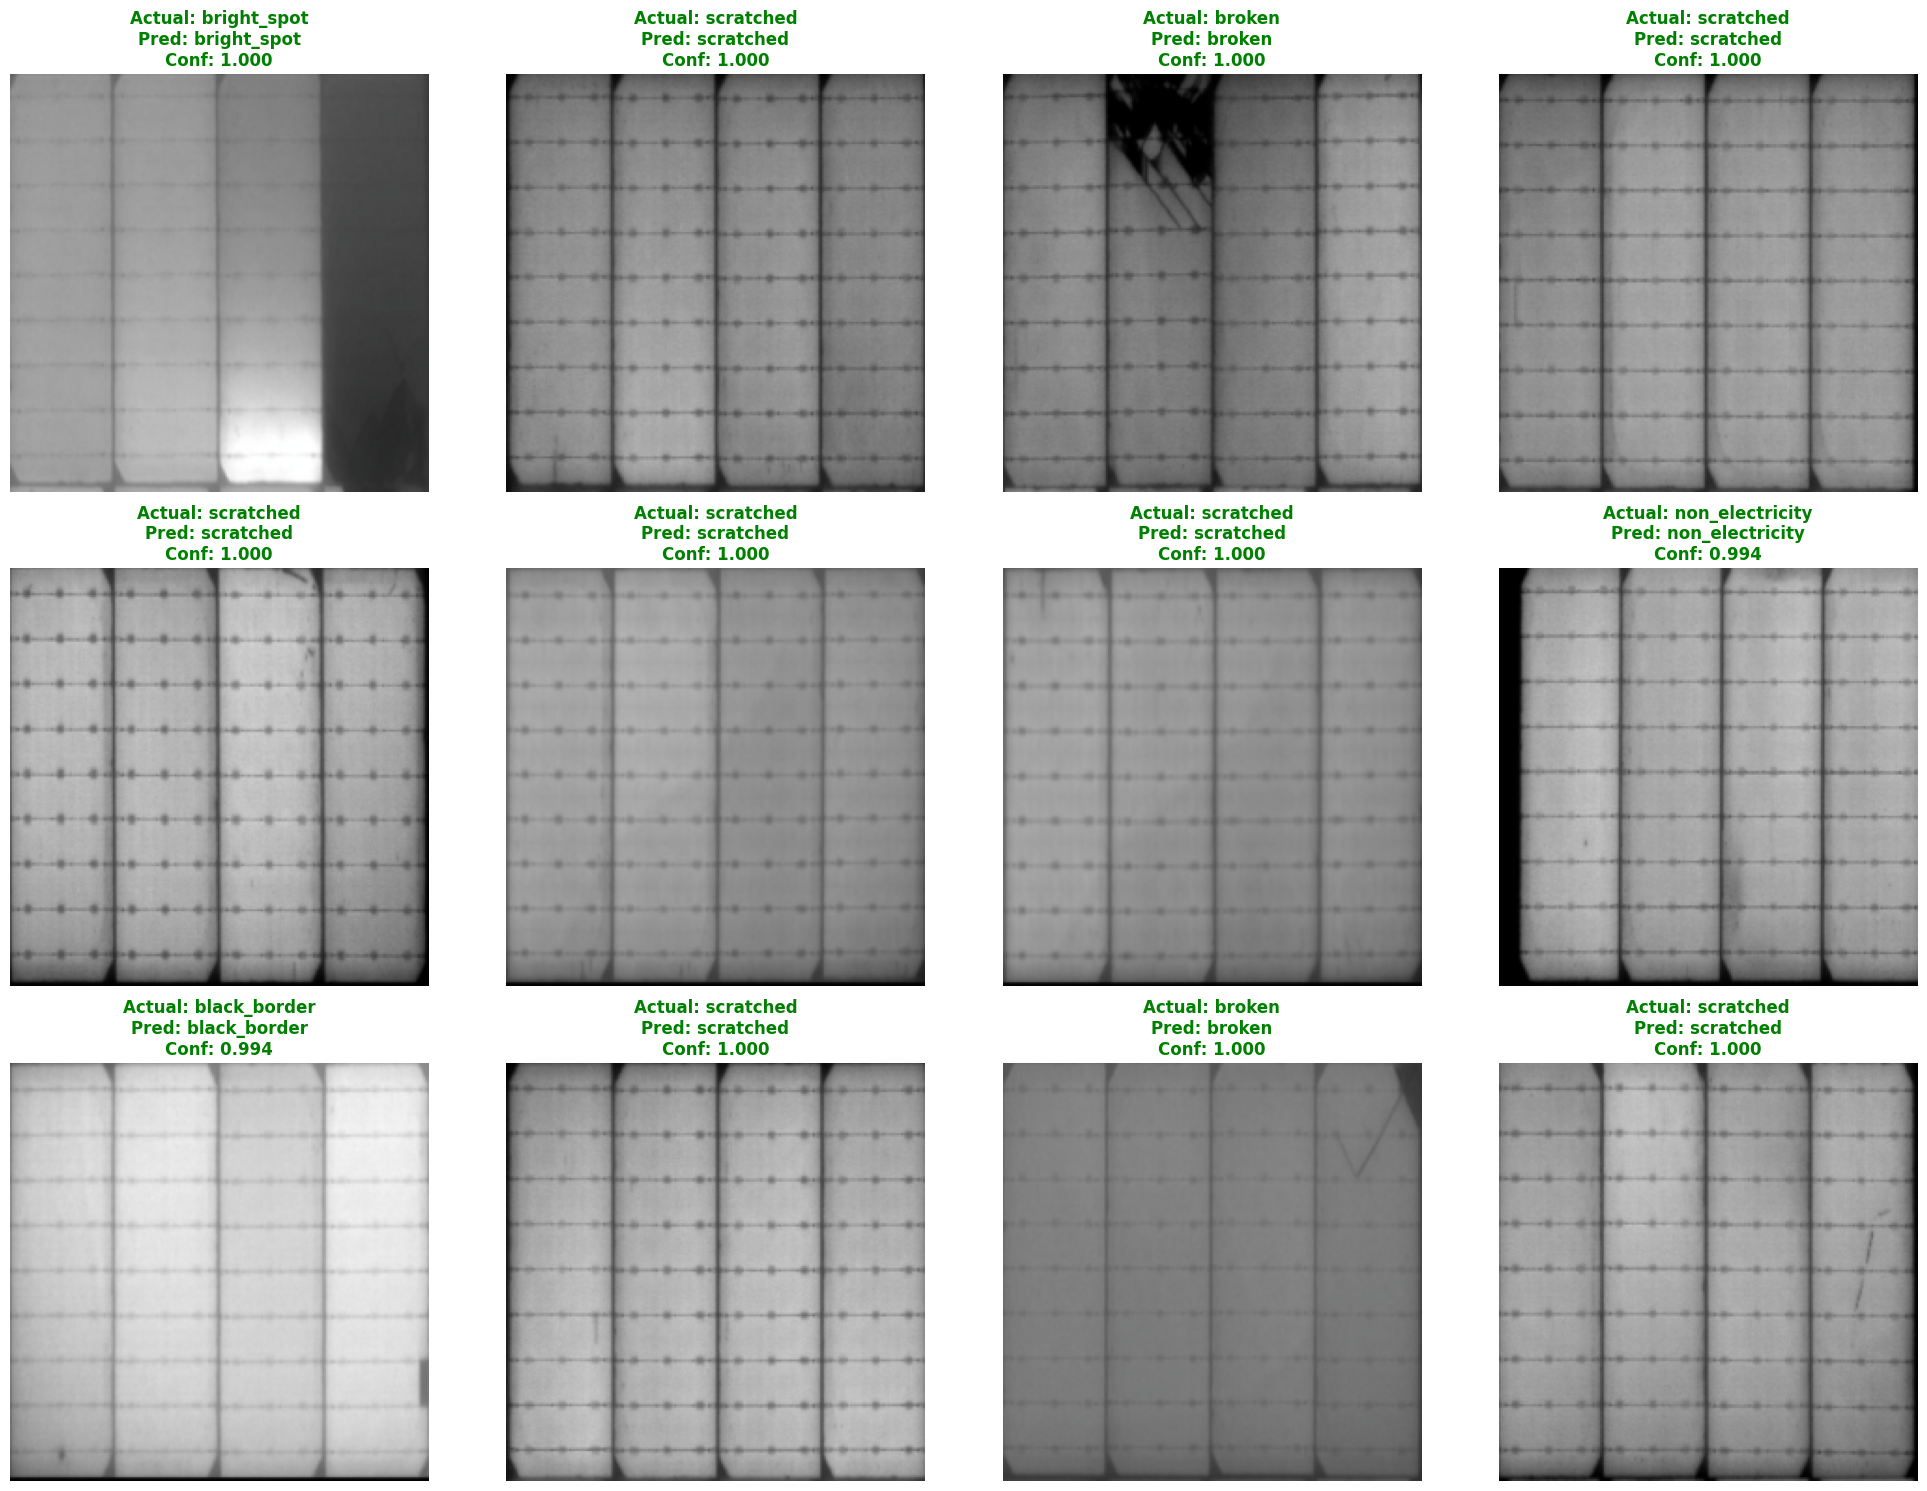

✅ Final model and results saved!
📊 Test Accuracy: 0.9401 (94.01%)

MODEL DEPLOYMENT READY
✅ Model loaded successfully!
📋 Classes: ['broken', 'bright_spot', 'black_border', 'scratched', 'non_electricity']

🧪 Testing on 3 sample images...
📷 img5217.jpg: scratched (confidence: 1.000)
📷 img155.jpg: black_border (confidence: 0.999)
📷 img6232.jpg: black_border (confidence: 1.000)

💾 Saving to Google Drive...
y


✅ All files saved to Google Drive: /content/drive/MyDrive/PV_Defect_Detection_20251019_190830

🎉 TRAINING COMPLETED SUCCESSFULLY!
📈 Final Test Accuracy: 0.9401 (94.01%)
💾 Models saved in: /content/models/
📊 Results saved in: /content/results/
🔧 Device used: cuda
📚 Dataset: PV-Multi-Defect (1105 samples)
🏷️  Classes: broken, bright_spot, black_border, scratched, non_electricity

Next steps:
1. Check /content/results/ for training plots and metrics
2. Use PVDefectPredictor for making new predictions
3. To resume training, simply run this script again
4. Models are automatically saved t

In [ ]:
# =============================================================================
# 1. INSTALLATION AND IMPORTS
# =============================================================================

# Install required libraries
!pip install torch torchvision torchaudio
!pip install ultralytics
!pip install albumentations
!pip install roboflow
!pip install opencv-python-headless
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tqdm
!pip install Pillow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import zipfile
from PIL import Image
import xml.etree.ElementTree as ET
from collections import defaultdict
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("CPU only - training will be slow!")

# Create directories
os.makedirs('/content/dataset', exist_ok=True)
os.makedirs('/content/models', exist_ok=True)
os.makedirs('/content/results', exist_ok=True)

# =============================================================================
# 2. DATA DOWNLOAD AND PREPARATION
# =============================================================================

# Clone the dataset repository
!git clone -q https://github.com/CCNUZFW/PV-Multi-Defect.git

# Check the dataset structure
dataset_path = '/content/PV-Multi-Defect'
print("Dataset contents:")
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        print(f"  📁 {item}: {len(os.listdir(item_path))} files")
    else:
        print(f"  📄 {item}")

# Check images and annotations
images_path = os.path.join(dataset_path, 'JPEGImages')
annotations_path = os.path.join(dataset_path, 'Annotations')

print(f"\nImages count: {len(os.listdir(images_path))}")
print(f"Annotations count: {len(os.listdir(annotations_path))}")

# =============================================================================
# 3. FIXED DATASET CLASS AND DATA LOADERS
# =============================================================================

class PVDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None, image_size=224):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_size = image_size

        # Get all image files
        self.image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Define defect classes based on the README
        self.classes = ['broken', 'bright_spot', 'black_border', 'scratched', 'non_electricity']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}

        # Parse annotations and create labels
        self.labels = self._parse_annotations()

        # Create list of valid samples (those with labels)
        self.samples = [(img_file, label) for img_file, label in self.labels.items()]

        print(f"Dataset initialized with {len(self.samples)} labeled images")
        print("Class distribution:")
        for cls, idx in self.class_to_idx.items():
            count = sum(1 for _, label in self.samples if label == idx)
            print(f"  {cls}: {count} samples")

    def _parse_annotations(self):
        labels = {}
        for img_file in self.image_files:
            base_name = os.path.splitext(img_file)[0]
            xml_file = os.path.join(self.annotations_dir, base_name + '.xml')

            if not os.path.exists(xml_file):
                # Skip images without annotation files
                continue

            try:
                # Parse XML annotation
                tree = ET.parse(xml_file)
                root = tree.getroot()

                # Count defects by type
                defect_count = defaultdict(int)
                for obj in root.findall('object'):
                    defect_type = obj.find('name').text.lower()

                    # Map to our defined classes based on the README descriptions
                    if any(word in defect_type for word in ['broken', 'crack']):
                        defect_count['broken'] += 1
                    elif any(word in defect_type for word in ['bright', 'spot', 'hot']):
                        defect_count['bright_spot'] += 1
                    elif any(word in defect_type for word in ['border', 'edge']):
                        defect_count['black_border'] += 1
                    elif any(word in defect_type for word in ['scratch', 'line']):
                        defect_count['scratched'] += 1
                    elif any(word in defect_type for word in ['non', 'black', 'dead', 'electricity']):
                        defect_count['non_electricity'] += 1
                    else:
                        # Default to broken if unknown
                        defect_count['broken'] += 1

                # Determine primary defect (most frequent)
                if defect_count:
                    primary_defect = max(defect_count.items(), key=lambda x: x[1])[0]
                    labels[img_file] = self.class_to_idx[primary_defect]

            except Exception as e:
                print(f"Error parsing {xml_file}: {e}")
                continue

        return labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, label = self.samples[idx]

        # Load image
        img_path = os.path.join(self.images_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (self.image_size, self.image_size), color='black')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        else:
            # Default transform
            transform = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])
            image = transform(image)

        return image, label, img_name

# Data augmentation and transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Initialize dataset
print("Loading dataset...")
full_dataset = PVDataset(images_path, annotations_path)

# Split dataset using indices (FIXED APPROACH)
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

print(f"\nDataset split:")
print(f"Total samples: {dataset_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Generate indices and split
indices = list(range(dataset_size))
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create subset datasets with proper transforms
from torch.utils.data import Subset

class TransformSubset(Subset):
    """Subset with transform support"""
    def __init__(self, dataset, indices, transform=None):
        super().__init__(dataset, indices)
        self.transform = transform
        self.dataset = dataset

    def __getitem__(self, idx):
        x, y, name = self.dataset[self.indices[idx]]
        if self.transform:
            x = self.transform(x)
        return x, y, name

# Create subsets with transforms
train_dataset = TransformSubset(full_dataset, train_indices, transform=train_transform)
val_dataset = TransformSubset(full_dataset, val_indices, transform=val_transform)
test_dataset = TransformSubset(full_dataset, test_indices, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nData loaders created with batch size: {batch_size}")

# =============================================================================
# 4. MODEL DEFINITION WITH TRANSFER LEARNING
# =============================================================================

class PVDefectClassifier(nn.Module):
    def __init__(self, num_classes=5, pretrained=True):
        super(PVDefectClassifier, self).__init__()

        # Load pre-trained ResNet50
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)

        # Freeze early layers for transfer learning
        if pretrained:
            # Freeze all backbone layers initially
            for param in self.backbone.parameters():
                param.requires_grad = False

            # Unfreeze the last few layers for fine-tuning
            for param in self.backbone.layer4.parameters():
                param.requires_grad = True

        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

    def unfreeze_all(self):
        """Unfreeze all layers for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True

# Initialize model
print("\nInitializing model...")
model = PVDefectClassifier(num_classes=5, pretrained=True)
model = model.to(device)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# =============================================================================
# 5. TRAINING SETUP WITH CHECKPOINTING
# =============================================================================

def setup_training(model, learning_rate=0.001):
    """Setup loss function, optimizer, and scheduler"""
    criterion = nn.CrossEntropyLoss()

    # Only optimize parameters that require gradients
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=1e-4
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    return criterion, optimizer, scheduler

criterion, optimizer, scheduler = setup_training(model)

def find_latest_checkpoint():
    """Find the latest checkpoint to resume training"""
    if not os.path.exists('/content/models'):
        return None

    checkpoint_files = [f for f in os.listdir('/content/models') if f.startswith('checkpoint_epoch_')]
    if checkpoint_files:
        latest_epoch = max([int(f.split('_')[-1].split('.')[0]) for f in checkpoint_files])
        latest_checkpoint = f'/content/models/checkpoint_epoch_{latest_epoch}.pth'
        return latest_checkpoint
    return None

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    pbar = tqdm(dataloader, desc="Training")
    for batch_idx, (inputs, labels, _) in enumerate(pbar):
        inputs = inputs.to(device)
        labels = labels.to(device)
        batch_size = inputs.size(0)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds == labels.data)
        total_samples += batch_size

        # Update progress bar
        if batch_idx % 10 == 0:
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{torch.sum(preds == labels.data).item() / batch_size:.4f}'
            })

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for inputs, labels, _ in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.size(0)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data)
            total_samples += batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, resume_from=None):
    """Main training function with checkpointing"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_epoch = 0
    best_val_acc = 0.0

    # Resume training if checkpoint exists
    if resume_from and os.path.exists(resume_from):
        print(f"Loading checkpoint: {resume_from}")
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        train_accuracies = checkpoint.get('train_accuracies', [])
        val_accuracies = checkpoint.get('val_accuracies', [])
        best_val_acc = checkpoint.get('best_val_acc', 0.0)
        print(f"Resumed training from epoch {start_epoch}")

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.cpu().item())

        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.cpu().item())

        # Step scheduler
        scheduler.step()

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'best_val_acc': best_val_acc
        }

        torch.save(checkpoint, f'/content/models/checkpoint_epoch_{epoch}.pth')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/content/models/best_model.pth')
            print(f'🎯 New best model saved with validation accuracy: {best_val_acc:.4f}')

        # Save latest model
        torch.save(model.state_dict(), '/content/models/latest_model.pth')

        # Early stopping check (optional)
        if epoch > 10 and len(val_accuracies) > 10:
            if max(val_accuracies[-10:]) == max(val_accuracies[:-10]):
                print("Validation accuracy not improving, consider early stopping.")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Start training
latest_checkpoint = find_latest_checkpoint()
if latest_checkpoint:
    print(f"Resuming from checkpoint: {latest_checkpoint}")

print("\nStarting training process...")
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=30, resume_from=latest_checkpoint
)

# =============================================================================
# 6. VISUALIZATION AND ANALYSIS
# =============================================================================

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', linewidth=2)
    ax2.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/results/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nPlotting training history...")
if train_losses:  # Only plot if we have training data
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

# =============================================================================
# 7. MODEL EVALUATION
# =============================================================================

def evaluate_model(model, test_loader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_filenames = []

    with torch.no_grad():
        for inputs, labels, filenames in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_filenames.extend(filenames)

    return all_preds, all_labels, all_probs, all_filenames

# Load best model for evaluation
print("\nLoading best model for evaluation...")
if os.path.exists('/content/models/best_model.pth'):
    model.load_state_dict(torch.load('/content/models/best_model.pth', map_location=device))
else:
    print("Best model not found, using current model for evaluation")

# Evaluate on test set
print("Evaluating on test set...")
all_preds, all_labels, all_probs, all_filenames = evaluate_model(model, test_loader, device)

# Calculate metrics
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
class_names = ['broken', 'bright_spot', 'black_border', 'scratched', 'non_electricity']

print(f"\n{'='*50}")
print("FINAL MODEL EVALUATION")
print(f"{'='*50}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('/content/results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 8. PREDICTION VISUALIZATION
# =============================================================================

def visualize_predictions(model, test_loader, device, num_samples=12):
    """Visualize model predictions"""
    model.eval()

    # Get a batch of test samples
    data_iter = iter(test_loader)
    images, labels, filenames = next(data_iter)

    # Make predictions
    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

    # Convert to numpy for visualization
    images_np = images.cpu().numpy()

    # Plot results
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = images_np[i].transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Get prediction info
        actual_class = class_names[labels[i]]
        pred_class = class_names[preds[i]]
        confidence = probs[i][preds[i]].item()

        # Plot
        axes[i].imshow(img)
        color = 'green' if preds[i] == labels[i] else 'red'
        axes[i].set_title(f'Actual: {actual_class}\nPred: {pred_class}\nConf: {confidence:.3f}',
                         color=color, fontsize=12, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('/content/results/predictions_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nVisualizing predictions...")
visualize_predictions(model, test_loader, device)

# =============================================================================
# 9. SAVE FINAL MODEL AND RESULTS
# =============================================================================

def save_final_model_and_results(model, test_accuracy, all_preds, all_labels, all_probs, all_filenames):
    """Save final model and all results"""

    # Save the complete model with metadata
    model_info = {
        'model_state_dict': model.state_dict(),
        'test_accuracy': test_accuracy,
        'class_names': class_names,
        'class_to_idx': full_dataset.class_to_idx,
        'input_size': 224,
        'num_classes': 5,
        'model_architecture': 'ResNet50_TransferLearning'
    }

    torch.save(model_info, '/content/models/final_pv_defect_model.pth')

    # Save predictions with probabilities
    results_df = pd.DataFrame({
        'filename': all_filenames,
        'actual': [class_names[label] for label in all_labels],
        'predicted': [class_names[pred] for pred in all_preds],
        'confidence': [max(probs) for probs in all_probs],
        'is_correct': [pred == label for pred, label in zip(all_preds, all_labels)]
    })

    # Add probability for each class
    for i, class_name in enumerate(class_names):
        results_df[f'prob_{class_name}'] = [prob[i] for prob in all_probs]

    results_df.to_csv('/content/results/test_predictions_detailed.csv', index=False)

    # Save training summary
    summary = {
        'final_test_accuracy': test_accuracy,
        'best_val_accuracy': max(val_accuracies) if val_accuracies else 0,
        'final_train_accuracy': train_accuracies[-1] if train_accuracies else 0,
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'training_epochs': len(train_accuracies) if train_accuracies else 0,
        'batch_size': batch_size,
        'model_architecture': 'ResNet50 with custom classifier',
        'dataset': 'PV-Multi-Defect from CCNUZFW'
    }

    with open('/content/results/training_summary.txt', 'w') as f:
        f.write("PV DEFECT DETECTION MODEL - TRAINING SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        for key, value in summary.items():
            f.write(f"{key.replace('_', ' ').title()}: {value}\n")

    # Save class distribution
    class_dist = pd.DataFrame({
        'class': class_names,
        'count': [sum(1 for label in all_labels if label == i) for i in range(len(class_names))]
    })
    class_dist.to_csv('/content/results/class_distribution.csv', index=False)

    print("✅ Final model and results saved!")
    print(f"📊 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

save_final_model_and_results(model, test_accuracy, all_preds, all_labels, all_probs, all_filenames)

# =============================================================================
# 10. MODEL DEPLOYMENT AND INFERENCE EXAMPLE
# =============================================================================

class PVDefectPredictor:
    """Class for making predictions with the trained model"""

    def __init__(self, model_path, device='cuda'):
        self.device = device
        # Load model with weights_only=False
        self.model_info = torch.load(model_path, map_location=device, weights_only=False)
        self.class_names = self.model_info['class_names']

        # Initialize model
        self.model = PVDefectClassifier(num_classes=len(self.class_names), pretrained=False)
        self.model.load_state_dict(self.model_info['model_state_dict'])
        self.model.to(device)
        self.model.eval()

        # Define transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image_path):
        """Make prediction on a single image"""
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Make prediction
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probs = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probs, 1)

        return {
            'class': self.class_names[predicted.item()],
            'confidence': confidence.item(),
            'all_probabilities': {
                cls: prob.item() for cls, prob in zip(self.class_names, probs.squeeze())
            }
        }

# Example usage
print("\n" + "="*60)
print("MODEL DEPLOYMENT READY")
print("="*60)

# Initialize predictor
predictor = PVDefectPredictor('/content/models/final_pv_defect_model.pth', device)

print("✅ Model loaded successfully!")
print(f"📋 Classes: {class_names}")

# Test on a few sample images
sample_images = [os.path.join(images_path, f) for f in os.listdir(images_path)[:3]]
if sample_images:
    print(f"\n🧪 Testing on {len(sample_images)} sample images...")
    for img_path in sample_images:
        try:
            result = predictor.predict(img_path)
            print(f"📷 {os.path.basename(img_path)}: {result['class']} (confidence: {result['confidence']:.3f})")
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")

# =============================================================================
# 11. SAVE TO GOOGLE DRIVE
# =============================================================================

def save_to_drive():
    """Save all results to Google Drive"""
    try:
        # Create timestamped folder
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        drive_folder = f'/content/drive/MyDrive/PV_Defect_Detection_{timestamp}'

        os.makedirs(drive_folder, exist_ok=True)

        # Copy models and results
        !cp -r /content/models {drive_folder}/
        !cp -r /content/results {drive_folder}/

        # Save training script
        with open(f'{drive_folder}/training_script.py', 'w') as f:
            f.write("# PV Defect Detection Training Script\n")
            f.write(f"# Trained on: {timestamp}\n")
            f.write(f"# Final Test Accuracy: {test_accuracy:.4f}\n")

        print(f"✅ All files saved to Google Drive: {drive_folder}")

    except Exception as e:
        print(f"❌ Error saving to Google Drive: {e}")

# Uncomment to save to Google Drive
print("\n💾 Saving to Google Drive...")
save_to_drive()

# =============================================================================
# 12. FINAL SUMMARY
# =============================================================================

print("\n" + "="*70)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"📈 Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"💾 Models saved in: /content/models/")
print(f"📊 Results saved in: /content/results/")
print(f"🔧 Device used: {device}")
print(f"📚 Dataset: PV-Multi-Defect ({dataset_size} samples)")
print(f"🏷️  Classes: {', '.join(class_names)}")
print("\nNext steps:")
print("1. Check /content/results/ for training plots and metrics")
print("2. Use PVDefectPredictor for making new predictions")
print("3. To resume training, simply run this script again")
print("4. Models are automatically saved to Google Drive")
print("="*70)

# Display final results
final_results = {
    'Training Samples': len(train_dataset),
    'Validation Samples': len(val_dataset),
    'Test Samples': len(test_dataset),
    'Final Test Accuracy': f"{test_accuracy:.4f}",
    'Best Validation Accuracy': f"{max(val_accuracies):.4f}" if val_accuracies else "N/A",
    'Model Parameters': f"{sum(p.numel() for p in model.parameters()):,}",
    'Trainable Parameters': f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
}

print("\n📋 FINAL RESULTS SUMMARY:")
for key, value in final_results.items():
    print(f"  {key}: {value}")

In [2]:
# =============================================================================
# SIMPLE MODEL TESTING WITH NEW IMAGES - FIXED VERSION
# =============================================================================


from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

def test_pv_defect_model():
    """Simple function to test your trained PV defect model"""

    print("🔍 PV DEFECT DETECTION - IMAGE TESTER")
    print("=" * 50)

    # Define class names at the start
    class_names = ['broken', 'bright_spot', 'black_border', 'scratched', 'non_electricity']

    # Load your trained model with weights_only=False
    print("📦 Loading your trained model...")
    try:
        model_path = 'models\final_pv_defect_model.pth'

        # Load with weights_only=False to handle compatibility
        model_info = torch.load(model_path, map_location=device, weights_only=False)

        # Initialize model
        model = PVDefectClassifier(num_classes=5, pretrained=False)
        model.load_state_dict(model_info['model_state_dict'])
        model.to(device)
        model.eval()

        print("✅ Model loaded successfully!")
        print(f"📋 Classes: {class_names}")

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("🔄 Trying alternative loading method...")

        # Alternative loading method
        try:
            model_path = 'models\best_model.pth'
            model = PVDefectClassifier(num_classes=5, pretrained=False)
            model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
            model.to(device)
            model.eval()
            print("✅ Model loaded successfully using alternative method!")
            print(f"📋 Classes: {class_names}")
        except Exception as e2:
            print(f"❌ Failed to load model: {e2}")
            return

    # Image transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Upload and test images
    print("\n📁 Upload PV panel images for defect detection...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No images uploaded!")
        return

    # Process each uploaded image
    for image_name in uploaded.keys():
        print(f"\n📷 Processing: {image_name}")

        try:
            # Load image
            image = Image.open(image_name).convert('RGB')

            # Preprocess and predict
            input_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probs, 1)

            # Get results
            predicted_class = class_names[predicted.item()]
            confidence_score = confidence.item()

            # Display results
            print("🔍 PREDICTION RESULTS:")
            print(f"   🎯 Defect Type: {predicted_class}")
            print(f"   📊 Confidence: {confidence_score:.3f}")

            # Show all probabilities
            print("   📈 Class Probabilities:")
            for i, cls in enumerate(class_names):
                prob = probs[0][i].item()
                print(f"      {cls}: {prob:.3f}")

            # Display image with prediction
            plt.figure(figsize=(10, 6))
            plt.imshow(image)
            plt.title(f'PV Panel Defect Detection\nPredicted: {predicted_class} (Confidence: {confidence_score:.3f})',
                     fontsize=14, fontweight='bold', pad=20)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            # Confidence interpretation
            if confidence_score > 0.9:
                confidence_level = "Very High"
            elif confidence_score > 0.7:
                confidence_level = "High"
            elif confidence_score > 0.5:
                confidence_level = "Moderate"
            else:
                confidence_level = "Low"

            print(f"   💡 Confidence Level: {confidence_level}")

        except Exception as e:
            print(f"❌ Error processing {image_name}: {e}")

    print("\n" + "=" * 50)
    print("✅ Testing completed!")
    print("🔄 Run this cell again to test more images")

# Run the testing function
test_pv_defect_model()

🔍 PV DEFECT DETECTION - IMAGE TESTER
📦 Loading your trained model...
❌ Error loading model: name 'device' is not defined
🔄 Trying alternative loading method...
❌ Failed to load model: name 'PVDefectClassifier' is not defined


In [ ]:
import sys
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
from PyQt5.QtWidgets import (QApplication, QMainWindow, QVBoxLayout, QHBoxLayout, 
                             QPushButton, QLabel, QFileDialog, QWidget, QTextEdit,
                             QProgressBar, QMessageBox)
from PyQt5.QtCore import Qt, QThread, pyqtSignal
from PyQt5.QtGui import QPixmap, QFont

# Define the same model architecture used during training
class SolarDefectDetector(nn.Module):
    def __init__(self, num_classes=5):
        super(SolarDefectDetector, self).__init__()
        # Using EfficientNet-B0 as base (same as in your training)
        self.backbone = models.efficientnet_b0(pretrained=False)
        # Replace the classifier
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

class PredictionThread(QThread):
    prediction_finished = pyqtSignal(str, str, dict)
    error_occurred = pyqtSignal(str)
    
    def __init__(self, model, image_path, class_names):
        super().__init__()
        self.model = model
        self.image_path = image_path
        self.class_names = class_names
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def run(self):
        try:
            # Load and preprocess image
            image = Image.open(self.image_path).convert('RGB')
            input_tensor = self.transform(image).unsqueeze(0)
            
            # Make prediction
            self.model.eval()
            with torch.no_grad():
                outputs = self.model(input_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probabilities, 1)
                
            # Get results
            predicted_class = self.class_names[predicted.item()]
            confidence_score = confidence.item()
            
            # Get all class probabilities
            all_probs = {}
            for i, class_name in enumerate(self.class_names):
                all_probs[class_name] = probabilities[0][i].item()
            
            self.prediction_finished.emit(
                predicted_class, 
                f"{confidence_score:.4f}", 
                all_probs
            )
            
        except Exception as e:
            self.error_occurred.emit(str(e))

class SolarDefectApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.model = None
        self.class_names = ['broken', 'bright_spot', 'black_border', 'scratched', 'non_electricity']
        self.init_ui()
        self.load_model()
        
    def init_ui(self):
        self.setWindowTitle("Solar Panel Defect Detection")
        self.setFixedSize(800, 700)
        
        # Central widget
        central_widget = QWidget()
        self.setCentralWidget(central_widget)
        
        # Main layout
        layout = QVBoxLayout()
        
        # Title
        title = QLabel("Solar Panel Defect Detection")
        title.setAlignment(Qt.AlignCenter)
        title.setFont(QFont("Arial", 18, QFont.Bold))
        layout.addWidget(title)
        
        # Image display
        self.image_label = QLabel()
        self.image_label.setAlignment(Qt.AlignCenter)
        self.image_label.setMinimumHeight(300)
        self.image_label.setStyleSheet("border: 2px dashed gray;")
        self.image_label.setText("No image selected")
        layout.addWidget(self.image_label)
        
        # Button layout
        button_layout = QHBoxLayout()
        
        self.load_btn = QPushButton("Load Image")
        self.load_btn.clicked.connect(self.load_image)
        self.load_btn.setStyleSheet("QPushButton { background-color: #4CAF50; color: white; font-size: 14px; padding: 10px; }")
        button_layout.addWidget(self.load_btn)
        
        self.predict_btn = QPushButton("Predict Defect")
        self.predict_btn.clicked.connect(self.predict_defect)
        self.predict_btn.setEnabled(False)
        self.predict_btn.setStyleSheet("QPushButton { background-color: #2196F3; color: white; font-size: 14px; padding: 10px; }")
        button_layout.addWidget(self.predict_btn)
        
        layout.addLayout(button_layout)
        
        # Progress bar
        self.progress_bar = QProgressBar()
        self.progress_bar.setVisible(False)
        layout.addWidget(self.progress_bar)
        
        # Results area
        results_label = QLabel("Prediction Results:")
        results_label.setFont(QFont("Arial", 12, QFont.Bold))
        layout.addWidget(results_label)
        
        self.results_text = QTextEdit()
        self.results_text.setReadOnly(True)
        self.results_text.setMaximumHeight(200)
        layout.addWidget(self.results_text)
        
        # Probabilities display
        self.probs_text = QTextEdit()
        self.probs_text.setReadOnly(True)
        self.probs_text.setMaximumHeight(150)
        layout.addWidget(self.probs_text)
        
        central_widget.setLayout(layout)
        
    def load_model(self):
        try:
            # Initialize model
            self.model = SolarDefectDetector(num_classes=len(self.class_names))
            
            # Load trained weights
            model_path = "models/best_model.pth"
            if os.path.exists(model_path):
                checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
                
                # Handle different checkpoint formats
                if 'model_state_dict' in checkpoint:
                    self.model.load_state_dict(checkpoint['model_state_dict'])
                elif 'state_dict' in checkpoint:
                    self.model.load_state_dict(checkpoint['state_dict'])
                else:
                    self.model.load_state_dict(checkpoint)
                
                self.model.eval()
                self.results_text.setText("Model loaded successfully!")
                print("Model loaded successfully!")
            else:
                self.show_error(f"Model file not found at: {model_path}\nPlease make sure 'models/best_model.pth' exists.")
                
        except Exception as e:
            self.show_error(f"Error loading model: {str(e)}")
    
    def load_image(self):
        file_path, _ = QFileDialog.getOpenFileName(
            self, "Select Solar Panel Image", "", 
            "Image Files (*.png *.jpg *.jpeg *.bmp *.tiff)"
        )
        
        if file_path:
            self.current_image_path = file_path
            pixmap = QPixmap(file_path)
            
            # Scale image to fit label while maintaining aspect ratio
            scaled_pixmap = pixmap.scaled(
                self.image_label.width() - 20, 
                self.image_label.height() - 20,
                Qt.KeepAspectRatio, 
                Qt.SmoothTransformation
            )
            
            self.image_label.setPixmap(scaled_pixmap)
            self.predict_btn.setEnabled(True)
            self.results_text.clear()
            self.probs_text.clear()
    
    def predict_defect(self):
        if hasattr(self, 'current_image_path'):
            self.progress_bar.setVisible(True)
            self.progress_bar.setRange(0, 0)  # Indeterminate progress
            self.predict_btn.setEnabled(False)
            self.load_btn.setEnabled(False)
            
            # Start prediction in separate thread
            self.prediction_thread = PredictionThread(
                self.model, 
                self.current_image_path, 
                self.class_names
            )
            self.prediction_thread.prediction_finished.connect(self.on_prediction_finished)
            self.prediction_thread.error_occurred.connect(self.on_prediction_error)
            self.prediction_thread.start()
    
    def on_prediction_finished(self, predicted_class, confidence, all_probs):
        self.progress_bar.setVisible(False)
        self.predict_btn.setEnabled(True)
        self.load_btn.setEnabled(True)
        
        # Display main results
        result_text = f"Predicted Defect: {predicted_class}\n"
        result_text += f"Confidence: {confidence}\n\n"
        
        # Color code based on defect type
        if predicted_class == "non_electricity":
            result_text += "Status: ✅ No critical defects detected"
        else:
            result_text += f"Status: ⚠️ Defect detected - {predicted_class}"
        
        self.results_text.setText(result_text)
        
        # Display all probabilities
        probs_text = "All Class Probabilities:\n"
        for class_name, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
            probs_text += f"{class_name}: {prob:.4f}\n"
        
        self.probs_text.setText(probs_text)
    
    def on_prediction_error(self, error_message):
        self.progress_bar.setVisible(False)
        self.predict_btn.setEnabled(True)
        self.load_btn.setEnabled(True)
        self.show_error(f"Prediction error: {error_message}")
    
    def show_error(self, message):
        QMessageBox.critical(self, "Error", message)
    
    def resizeEvent(self, event):
        # Update image scaling when window is resized
        if hasattr(self, 'current_image_path') and self.current_image_path:
            pixmap = QPixmap(self.current_image_path)
            scaled_pixmap = pixmap.scaled(
                self.image_label.width() - 20, 
                self.image_label.height() - 20,
                Qt.KeepAspectRatio, 
                Qt.SmoothTransformation
            )
            self.image_label.setPixmap(scaled_pixmap)
        super().resizeEvent(event)

def main():
    app = QApplication(sys.argv)
    
    # Set application style
    app.setStyleSheet("""
        QMainWindow {
            background-color: #f0f0f0;
        }
        QTextEdit {
            background-color: white;
            border: 1px solid #ccc;
            border-radius: 5px;
            padding: 5px;
        }
        QLabel {
            padding: 5px;
        }
    """)
    
    window = SolarDefectApp()
    window.show()
    
    sys.exit(app.exec_())

if __name__ == "__main__":
    main()

c:\Users\PC3\anaconda3\envs\finalproject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC3\anaconda3\envs\finalproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
pip install PyQt5 

   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.9 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.9 MB 764.3 kB/s eta 0:00:09
   ---- ----------------------------------- 0.8/6.9 MB 714.3 kB/s eta 0:00:09
   ---- ----------------------------------- 0.8/6.9 MB 714.3 kB/s eta 0:00:09
   ------ --------------------------------- 1.0/6.9 MB 729.5 kB/s eta 0:00:08
   ------ --------------------------------- 1.0/6.9 MB 729.5 kB/s eta 0:00:08
   ------- -------------------------------- 1.3/6.9 MB 737.4 kB/s eta 0:00:08
   --------- ------------------------------ 1.6/6.9 MB 769.7 kB/s eta 0:00:07
   ---------- --------------------------